# Spectroscopy with XGA

This tutorial will show you how to perform basic spectroscopic analyses on XGA sources, starting with how to generate spectra for a source using the SAS interface. Once I have demonstrated how to generate the spectra for a source, I will show how we can use the XSPEC interface to fit a model to the data, and then how we can retrieve the fit results.

I will also demonstrate the use of the spectrum product view method, to produce visualisations of spectra roughly equivalent to those that XSPEC produces. 

In [1]:
from astropy.units import Quantity
import numpy as np
import pandas as pd

from xga.samples import ClusterSample
from xga.sources import PointSource
from xga.sas import evselect_spectrum
from xga.xspec import single_temp_apec, power_law

I need to define some sources to help demonstrate, and I've chosen to define both a sample of galaxy clusters (to demonstrate fitting a standard absorbed plasma emission model), and a point source (representing a quasar) to demonstrate the fitting of a redshift dependant absorbed power law).

Again I've chosen four clusters from the XCS-SDSS sample:

In [2]:
# Setting up the column names and numpy array that go into the Pandas dataframe
column_names = ['name', 'ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']
cluster_data = np.array([['XCSSDSS-124', 0.80057775, -6.0918182, 0.251, 1220.11, 1777.06, 109.55, 4.49],
                         ['XCSSDSS-2789', 0.95553986, 2.068019, 0.11, 1039.14, 1519.79, 38.90, 2.83],
                         ['XCSSDSS-290', 2.7226392, 29.161021, 0.338, 935.58, 1359.37, 105.10, 5.99],
                         ['XCSSDSS-134', 4.9083898, 3.6098177, 0.273, 1157.04, 1684.15, 108.60, 4.79]])

# Possibly I'm overcomplicating this by making it into a dataframe, but it is an excellent data structure,
#  and one that is very commonly used in my own analyses.
sample_df = pd.DataFrame(data=cluster_data, columns=column_names)
sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']] = \
    sample_df[['ra', 'dec', 'z', 'r500', 'r200', 'richness', 'richness_err']].astype(float)

# Defining the sample of four XCS-SDSS galaxy clusters
demo_smp = ClusterSample(sample_df["ra"].values, sample_df["dec"].values, sample_df["z"].values, 
                         sample_df["name"].values, r200=Quantity(sample_df["r200"].values, "kpc"),
                         r500=Quantity(sample_df["r500"].values, 'kpc'), richness=sample_df['richness'].values, 
                         richness_err=sample_df['richness_err'].values)

Setting up Galaxy Clusters: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Here I'm defining a point source object for a quasar at z~0.9, this object has no particular interest or significance (at least not to me), but it will be used to demonstrate the fitting of a powerlaw by XSPEC:

In [3]:
demo_src = PointSource(182.2416, 45.67667, 0.9254, name='PG1206+459')

Generating products of type(s) ccf: 100%|██████████| 1/1 [00:08<00:00,  8.86s/it]


## Generating spectra for our sources

It is just as simple to generate spectra (both for sample objects and source objects) as it is to generate the photometric products that we used in the last tutorial. The primary extra information required by evselect_spectrum is a region in which to generate the spectra, for a galaxy cluster it might be an overdensity radius (like R$_{200}$ for instance), for a point source we would use the 'point' region, as defined on point source initilisation with the ``point_radius`` keyword argument.

You can also set the level of grouping that you want to be applied to the spectrum (by the XMM SAS routine specgroup), using the ``min_counts``, ``min_sn``, and ``over_sample`` keyword arguments.

If the ``one_rmf`` keyword argument is set to True (as is the default) then only one RMF per ObsID-instrument combo will be generated, and will be used by any future spectrum generation for the ObsID-instrument combo. RMFs do change slightly with position on detector, but are also very computationally expensive to produce (relative to the other spectrum generation tasks), as such this is an acceptable compromise.

In [4]:
# For the quasar, we want to use the point region type
demo_src = evselect_spectrum(demo_src, 'point')

# Whereas for my sample of clusters I've decided I want to use the R500 regions
demo_smp = evselect_spectrum(demo_smp, 'r500')

Generating products of type(s) spectrum: 100%|██████████| 12/12 [54:54<00:00, 274.52s/it] 


## Generating core-excised spectra for our galaxy clusters

It is not unusual to want to measure quantities from spectra where the core of the galaxy cluster in question has been removed, though I will not go into the reasons for that here. It is not difficult to generate spectra like this in XGA, you simply pass an inner radius (that by default is set to zero), when calling evselect_spectrum:

In [5]:
demo_smp = evselect_spectrum(demo_smp, demo_smp.r500, demo_smp.r500*0.15)

Generating products of type(s) spectrum: 100%|██████████| 12/12 [38:22<00:00, 191.84s/it]


## A note on ARF generation

The Auxiliary Response File (ARF), is an extremely important product which describes the change of the effective area of the telescope with energy, something that must be understood to try and recover the spectrum that was actually emitted by the object rather than the one that was recieved by the telescope. Calculating the ARF is a fairly complex process which, for XMM, is fully described in the [SAS documentation](http://xmm-tools.cosmos.esa.int/external/sas/current/doc/arfgen/), and as such the SAS *arfgen* procedure has numerous configuration options for the user to set.

XGA chooses to generate ARFs in two different ways, depending on whether the source being analysed is extended or point-like. For extended sources we generate a 'detector map', which is essentially an image of the source in detector coordinates, and acts to weight the calculation of the ARF curve by the emission of the source. For point sources this is not valid or necessary, so we do not use a detector map, and we set the `extendedsource` argument to False.

The use of the detector map to weight ARF generation for extended sources does extend the runtime, so do not be surprised if generating many spectra takes hours.

## How do the XSPEC fits work?

As XGA finds all available data relevant to a given source, we would ideally perform a model fit using every single spectrum that we generate, in order to get the best constraints. Unfortunately, we find that it is not always wise to use every single spectrum available, as if one or more are low quality, they can drag the whole fit down with them. 

As such we implemented a cleaning stage, almost identical to that used in the existing XCS luminosity-temperature pipeline, where (optionally) XSPEC fits can be performed on all of the spectra individually, and if certain quality requirements aren't met then that spectrum won't be included in the final, simultaneous, fit. More information about the default quality checks for the [single_temp_apec](../../xga.xspec.fit.html#xga.xspec.fit.general.single_temp_apec) function can be found in the documentation, and the checks can be disabled by setting `spectrum_checking=False`. The [power_law](../../xga.xspec.fit.html#xga.xspec.fit.general.power_law) function does not currently have any spectrum checking mechanism.

I have written a general XSPEC fitting script that in theory can deal with any model setup, and which is populated by XGA before being run for a specific source. Then the fit, luminosity, and plotting values are extracted and read into XGA. We simultaneously fit all valid spectra with the same model, making sure to link the key parameters so that the values are the result of minimising the difference of a single model to all the data.

Just as when we generate SAS products, this process runs in parallel, with four different source fits all being executed on different cores (for example), this is especially useful when analysing large samples of objects.

The default models implemented in XGA (an absorbed plasma model, and an absorbed powerlaw) both have an extra multiplicative constant, which helps us to deal with the different normalisations of spectra from different instruments and observations. The normalisations of all the spectra are linked, then the constant of the first spectrum in the dataset is frozen at 1, and all other constants are allowed to vary freely.

## Fitting models to our sources

For the quasar I've chosen a powerlaw, rather than any more complex model; there are two types of power law available to fit in the XGA XSPEC interface, an absorbed redshift dependant powerlaw (constant\*tbabs\*zpowerlw), and an absorbed redshift independent powerlaw (constant\*tbabs\*powerlaw). You can choose which model to fit using the ``redshifted`` keyword argument when power_law (imported from xga.xspec) is called, though of course only sources with redshift information are allowed to use the zpowerlw version.

For those sources which have redshift information, luminosity values will always be calculated after a fit is performed. A call to an XGA XSPEC function allows you to choose which energy band to calculate the luminosity in (the defaults are between 0.5-2.0keV and between 0.01-100keV).

The user may also choose a photon index to use as the start value for the XSPEC fit, using the ``start_pho_index`` parameter. The energy range of the data that is to be fit to can be selected with the ``lo_en`` and ``hi_en`` parameters, but passing Astropy quantities (the default range is 0.3-7.9keV). The hydrogen column value is taken from the source object and is (by default) frozen during the fit, this behaviour can be changed with the ``freeze_nh`` keyword argument.

In [6]:
demo_src = power_law(demo_src, 'point', redshifted=True)

Running XSPEC Fits: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


The model I have chosen to fit my clusters with is an absorbed APEC plasma emission model (constant\*tbabs\*apec), and the options you can pass into the function call are very similar to those of power_law. Start values for the temperature and metallicity of the plasma may be passed, along with parameters which will cause the nH and metallicity values to be frozen or unfrozen during the fit process:

In [7]:
demo_smp = single_temp_apec(demo_smp, 'r500')

Running XSPEC Fits: 100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


Seeing as I generated core-excised spectra for these galaxy clusters earlier, I will also fit the same model to those. It is worth noting here that if I hadn't already generated those core-excised spectra then this convenience function would have noticed that and generated them for me:

In [8]:
demo_smp = single_temp_apec(demo_smp, demo_smp.r500, demo_smp.r500*0.15)

Running XSPEC Fits: 100%|██████████| 4/4 [00:20<00:00,  5.11s/it]


## Saving fits to disk and loading them in again

Fit results are always saved to disk, and reside in the 'XSPEC' sub-directory of the 'xga_save_path' that is set in the configuration file. There they will be saved in another sub-directory with the name of the source in question.

If you decide to declare the same source again after you have already run a fit on it, you can choose to load the old fit in by setting the ``load_fits`` keyword argument to True on declaration of the source object. By default this is False however.

## Viewing fitted spectra

Its just as easy to visualise a spectrum as it is to visualise the photometric products we explored in the last tutorial. We simply use the view() method on a spectrum object and a data + model plot will be shown:

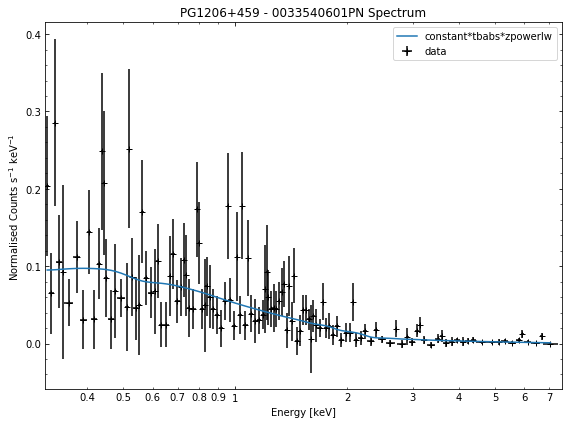

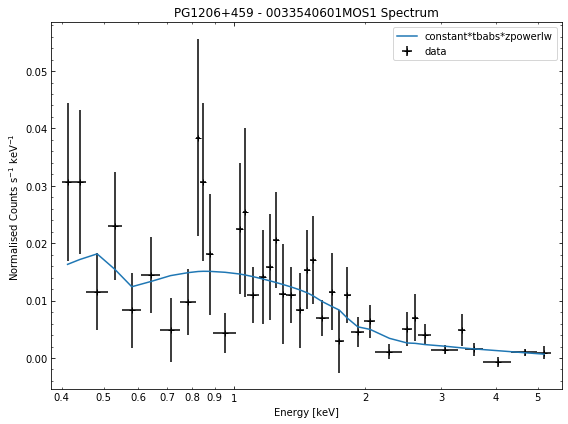

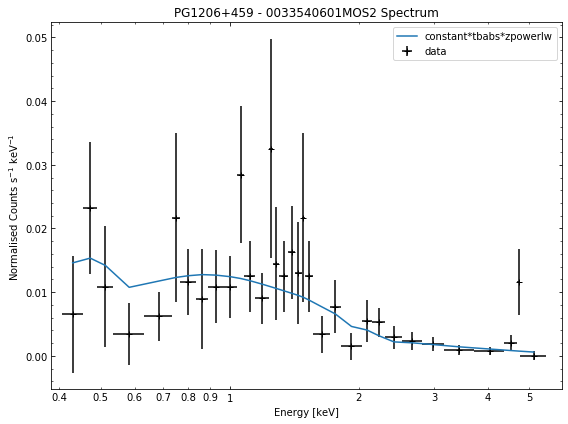

In [9]:
# Cycle through the spectra for the quasar and call their view methods
for sp in demo_src.get_spectra('point'):
    sp.view()

We do the same thing for the last cluster in our sample (XCSSDSS-134), both for the normal R$_{500}$ and core-excised spectra:


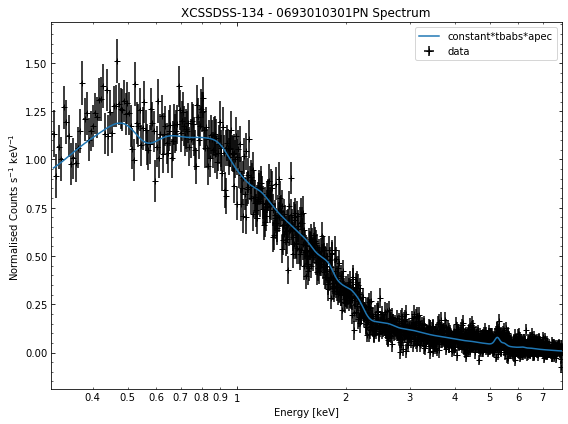

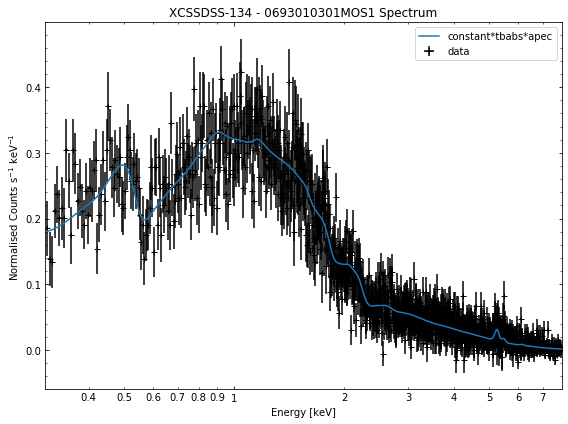

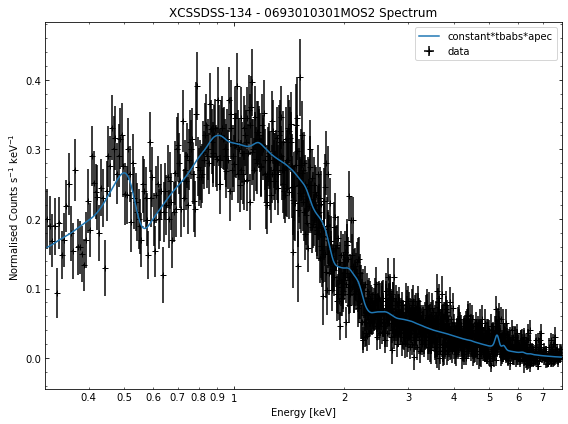

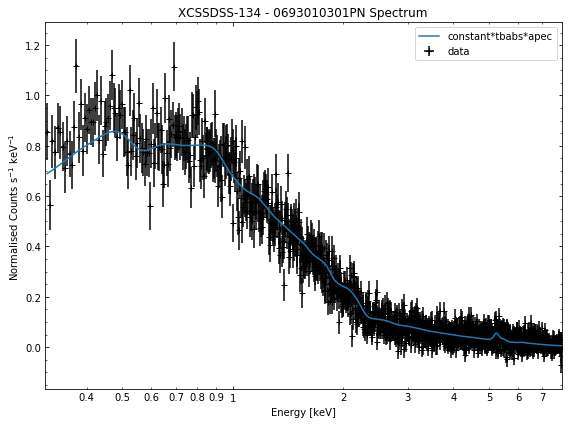

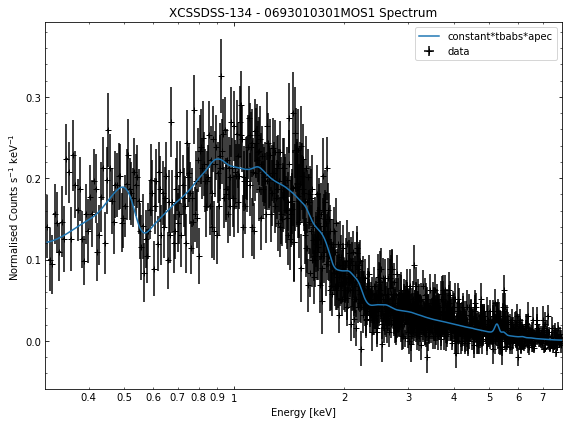

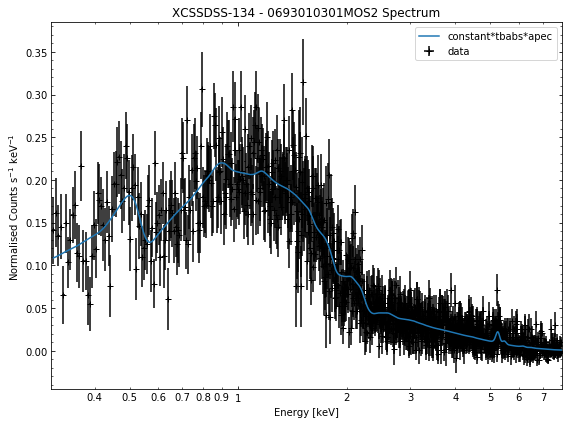

In [10]:
# Going through the R500 spectra
for sp in demo_smp[3].get_spectra('r500'):
    sp.view()
print('\n\n\n')

# Going through the core-excised spectra
for sp in demo_smp[3].get_spectra(demo_smp[3].r500, inner_radius=demo_smp[3].r500*0.15):
    sp.view()

## General retrieval of fit parameters

Once we have performed a fit, we will almost certainly want to know what the values of the fit parameters (as well as the uncertainties on those parameters). It is a simple matter to retrieve these fit values, you only need to supply the name of the model and the region the fit was run on. 

This information is passed into the 'get_results' method of a source object, and a dictionary of parameter values + uncertainties will be returned. For the quasar we have analysed as an example, the 'PhoIndex' entry is a numpy array with three values, the first column is the parameter value, the second column is the -error on the value, and the third column is the +error.

The 'factor' entry in the dictionary is the multiplicative constant we use to deal with differing normalisations of the separate spectra, there are only two entries (rather than the three you might expect due to there being three spectra) because one of them was set to one and frozen:

In [11]:
demo_src.get_results('point', 'constant*tbabs*zpowerlw')

{'PhoIndex': array([1.78984   , 0.07400441, 0.07558034]),
 'norm': array([1.68883000e-04, 1.27526738e-05, 1.31476429e-05]),
 'factor': array([[0.988555  , 0.10202081, 0.11219239],
        [0.821484  , 0.09475646, 0.10438363]])}

We can also use the exact same method on a GalaxyCluster source we get from our ClusterSample object. It is important to note that only parameters that are allowed to vary during the fit are saved in the fit paramater dictionaries. If, when we called 'single_temp_apec', we had allowed the nH and metalicity to vary, they would also have entries in the dictionary returned below:

In [12]:
demo_smp[3].get_results('r500', 'constant*tbabs*apec')

{'kT': array([6.66601   , 0.10205891, 0.10217485]),
 'norm': array([5.7889900e-03, 3.0805578e-05, 3.0887788e-05]),
 'factor': array([[1.0043    , 0.00974371, 0.00984066],
        [1.0067    , 0.00969691, 0.00980753]])}

Though do note that for a GalaxyCluster source object the model is set by default to constant\*tbabs\*apec, for convenience' sake, so you could just call `get_results` like this (I've added the inner_radius information so we're retrieving the results for the core-excised spectra):

In [13]:
demo_smp[3].get_results('r500', inner_radius=demo_smp[3].r500*0.15)

{'kT': array([6.33982   , 0.13287747, 0.13300562]),
 'norm': array([4.0435000e-03, 2.6871529e-05, 2.6958326e-05]),
 'factor': array([[0.970026  , 0.01215592, 0.01231316],
        [0.983651  , 0.01210961, 0.01226908]])}

## Parameters from GalaxyCluster and ClusterSample objects

Galaxy Clusters are my particular area of study, and the source objects that I most commonly analyse with XGA. As such I have built in certain methods to make the retrieval of things like the intra-cluster medium temperature as simple as possible, both from sources directly and samples of clusters.

Again the only information we need to provide are the name of the model and the region that the fit was run on. The method to use is `get_temperature`, and the default model it tries to get values for is 'constant\*tbabs\*apec':

In [14]:
# We take an individual GalaxyCluster source and retrieve its temperature and -+ temperature errors
print(demo_smp[3].get_temperature('r500'))

[6.66601    0.10205891 0.10217485] keV


When dealing with a sample of Galaxy Clusters however, we often wish to know the properties of the entire population, in which case we can use the 'Tx' method of the ClusterSample. Again the analysis radius must be passed, but the model is set by default to 'constant\*tbabs\*apec':

In [15]:
# This retrieves the T500 values (measured with constant*tbabs*apec) for the whole sample
print(demo_smp.Tx('r500'))

[[7.02059    0.12973252 0.12976439]
 [4.67254    0.08191512 0.08205011]
 [5.07272    0.27327653 0.27598913]
 [6.66601    0.10205891 0.10217485]] keV


## Retrieving L$_\rm{x}$ values from sources and samples

As I mentioned earlier, if a source has a redshift associated with it then L$_\rm{X}$ values will automatically be measured as part of the fitting process. The use of X-ray luminosities in analysis is extremely common in X-ray astronomy, so I have introduced methods to retrieve luminosities from any source or sample object, in much the same way as we retrieve T$_{\rm{x}}$ values from GalaxyCluster and ClusterSample objects.



Seeing as L$_\rm{X}$ values are measured within an energy band, I am defining the lower and upper limits of the measurement that I want to retrieve (as Astropy quantities), in this case the bolometric luminosity. If I didn't supply specific energy limits then the 'get_luminosities' method would supply all L$_\rm{X}$ measurements for the region-model combination in question.

Just as with the parameter dictionaries, the first column is the L$_\rm{X}$ value, the second is the -error, and the third is the +error:

In [16]:
lo_en = Quantity(0.01, 'keV')
hi_en = Quantity(100.0, 'keV')

In [17]:
# Grabbing the bolometric luminosity of the quasar we have investigated
print(demo_src.get_luminosities('point', 'constant*tbabs*zpowerlw', lo_en=lo_en, hi_en=hi_en), '\n')

# And all the r500 luminosities of the first cluster in our sample
print(demo_smp[0].get_luminosities('r500', 'constant*tbabs*apec'))

[2.28052016e+45 2.30134509e+44 1.62657738e+44] erg / s 

{'bound_0.5-2.0': <Quantity [5.78680953e+44, 2.94296973e+42, 2.74997150e+42] erg / s>, 'bound_0.01-100.0': <Quantity [2.23554673e+45, 1.63491236e+43, 1.60168515e+43] erg / s>}


In much the same way we can retrieve L$_\rm{X}$ values for an entire sample, and please note that this method can be used with any type of sample, not just ClusterSample objects:

In [18]:
# Bolometric luminosities for our sample of clusters
print(demo_smp.Lx('r500', 'constant*tbabs*apec', lo_en=lo_en, hi_en=hi_en))

[[2.23554673e+45 1.63491236e+43 1.60168515e+43]
 [3.74006375e+44 3.52762889e+42 3.06791738e+42]
 [9.55726922e+44 2.83318399e+43 2.93291919e+43]
 [1.87930718e+45 1.40294002e+43 1.49164499e+43]] erg / s


A final note on XGA's L$_\rm{X}$ values. When XSPEC performs a simultaneous fit to multiple spectra, and then a luminosity is measured, it actually measures luminosities individually for all the spectra. As such, I had to make a decision about which L$_\rm{X}$ values I wanted XGA to report when requested from a source or sample object.

I chose to preferentially report a PN luminosity (because of the greater sensitivity compared to the MOS cameras). If a PN spectra was not available, then a MOS2 luminosity is taken instead, and if MOS2 wasn't available then a MOS1 luminosity will be used.

## Generating annular spectra

The generation and use of annular spectra is dealt with in an advanced tutorial.